# Titanic Project with DNN

Predict survival on the Titanic using an artificial neural network in Keras

This project is based on a dataset containing demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on the [Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.


In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=9)
sns.set()

Using TensorFlow backend.


## Load and prepare the data

In [2]:
data_path = 'data/titanic_data.csv'
df = pd.read_csv(data_path)
df.head(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q


Some features (e.g. PassengerID, Name, Ticket) are irelevant to survival probabilities. Also some values are missing for key values (e.g. Age)

In [3]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']   # 'Embarked' removed to improve the model
targets = ['Survived']
df = df[features + targets]

df_original = df

# Reeplace NaN values with the mean value of the feature  (better results than using the median here)
df.fillna(df.mean(), inplace=True)

df.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Survived      int64
dtype: object

### Visualize the data

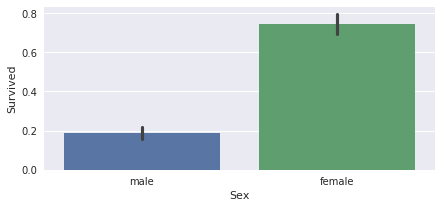

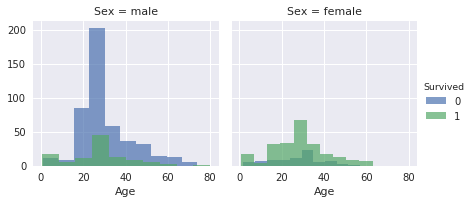

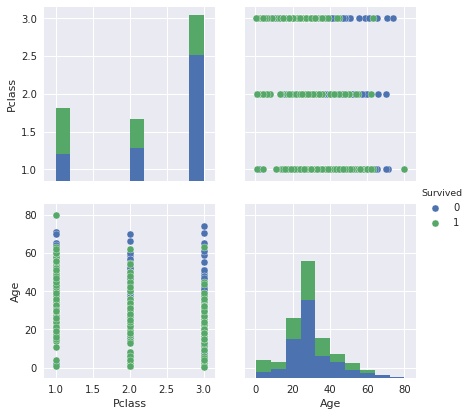

In [4]:
fig, ax = plt.subplots(figsize=[7,3])
sns.barplot(ax=ax, x='Sex',y='Survived', data=df)
sns.FacetGrid(df, col="Sex",hue="Survived", size=3).map(plt.hist, "Age", alpha=.7).add_legend();
#male_df = df[df['Sex']=='male']
sns.pairplot(df, size=3, hue='Survived', vars=['Pclass', 'Age'])


The sex of the passenger is the key feature for survival, as most women survived, followed by children under 6 approximately.

### Create dummy variables

In [5]:
dummy_fields = ['Sex']

# Process categorical variables 
dummy_fields = [d for d in dummy_fields if d in df]
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(dummy_fields, axis='columns')

features_list = list(df.drop(targets, axis=1))  # used later for manual predictions

### Scale numerical variables

In [6]:
quant_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Save scalings
scaled_features = {}
for f in quant_features:
    mean, std = df[f].mean(), df[f].std()
    scaled_features[f] = [mean, std]
    df.loc[:, f] = (df[f] - mean)/std

df.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male
0,0.826913,-0.592148,0.432550,-0.473408,-0.502163,0,0,1
1,-1.565228,0.638430,0.432550,-0.473408,0.786404,1,1,0
2,0.826913,-0.284503,-0.474279,-0.473408,-0.488580,1,1,0
3,-1.565228,0.407697,0.432550,-0.473408,0.420494,1,1,0
4,0.826913,0.407697,-0.474279,-0.473408,-0.486064,0,0,1


### Tune features selection

Fast way to remove features before training the model

In [7]:
fields_to_drop = []   # list with removed features
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'
data.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male
0,0.826913,-0.592148,0.432550,-0.473408,-0.502163,0,0,1
1,-1.565228,0.638430,0.432550,-0.473408,0.786404,1,1,0
2,0.826913,-0.284503,-0.474279,-0.473408,-0.488580,1,1,0
3,-1.565228,0.407697,0.432550,-0.473408,0.420494,1,1,0
4,0.826913,0.407697,-0.474279,-0.473408,-0.486064,0,0,1


### Split the data into training, and test sets

In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,  test_size=0.25, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
x_train, y_train_nc = train.drop(targets, axis=1).values, train[targets].values
x_test, y_test_nc = test.drop(targets, axis=1).values, test[targets].values
# _nc: non-categorical yet (needs one-hot encoding)


### One-hot encode the output

In [9]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print(x_train.shape ,y_train.shape)
print(x_test.shape,y_test.shape)

(668, 7) (668, 2)
(223, 7) (223, 2)


## Deep Neural Network
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 56)                448       
_________________________________________________________________
dropout_1 (Dropout)          (None, 56)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 114       
Total params: 562.0
Trainable params: 562.0
Non-trainable params: 0.0
_________________________________________________________________

Training ....
CPU times: user 4.9 s, sys: 72 ms, total: 4.97 s
Wall time: 4.99 s


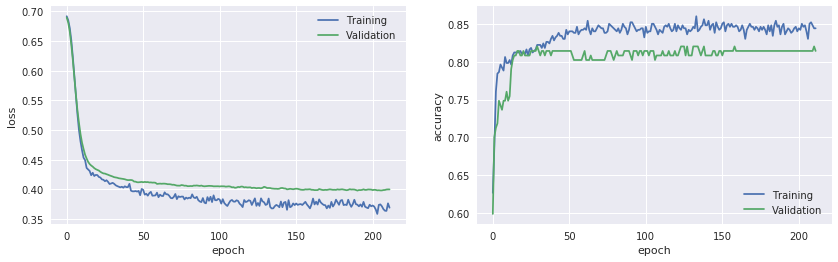


Training loss:  	0.3692
Validation loss: 	0.3999

Training accuracy: 	0.84
Validation accuracy:	0.81

Model saved at models/titanic.h5


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

input_nodes = x_train.shape[1]*8
weights = keras.initializers.RandomNormal(stddev=0.001)

model = Sequential()
model.add(Dense(input_nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = 'zero'))
model.add(Dropout(.2))
model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('\nTraining ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)]
%time history = model.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=0, validation_split=0.25, callbacks=callbacks)
helper.show_training(history)

model_path = os.path.join("models", "titanic.h5")
model.save(model_path)
print("\nModel saved at",model_path)

### Evaluate the model

In [11]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.2f}".format(score[1]))

Model loaded: models/titanic.h5

Test Accuracy: 0.79


**Results: **<br> 

| set | size | Acccuracy  |
|---------------|-------------|------------|
| Training   | 75% training data |  0.84 |
| Validation | 25% training data |  0.81 |
| Test | 25% dataset | 0.79 |


### Make predictions

In [12]:
# input data format
print(features_list)
df_original.describe()

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']


,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,0.836071,13.002015,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,29.699118,0.000000,0.000000,14.454200,0.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [13]:
def show_survival(passengers):
    # single_data: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
    
    print('Survival Probabilities: \n')
    
    for key, value in passengers.items():
            p_name = key
            single_data = value
    
            # normalize single data
            for idx, f in enumerate(quant_features):
                single_data[idx] = (single_data[idx]  - scaled_features[f][0])/scaled_features[f][1]

            # make prediction
            single_pred = model.predict(np.array([single_data]))    
            print('{}: \t {:.0f}%'.format(p_name,single_pred[0,1] * 100))

In [14]:
# single_data: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
new_passengers = {'Average man':  [2, 30, 1, 0, 14, 0, 1],
                  'Average woman':[2, 30, 1, 0, 14, 1, 0],
                  'Boy 1c':       [1, 12, 0, 2, 31, 0, 1],
                  'Boy 3c':       [3, 12, 0, 2, 8, 0, 1],
                  'Alone Boy 3c': [3, 12, 0, 0, 8, 0, 1],
                 }
show_survival(new_passengers)

Survival Probabilities: 

Average man: 	 7%
Average woman: 	 94%
Boy 1c: 	 94%
Boy 3c: 	 46%
Alone Boy 3c: 	 21%


The results predicted from the model confirms the impact of the sex for the survival probabilities, as well as the class and the presence of the parents for the survival of male teenagers.